In [3]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.metrics import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, LSTM, Bidirectional
from tensorflow.keras.optimizers import SGD
from keras.utils.vis_utils import plot_model

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler

import numpy.random as rand
import scipy.stats as stats 
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor 
from sklearn.model_selection import StratifiedKFold
from statsmodels.tsa.seasonal import seasonal_decompose

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date, timedelta, time, datetime
import time
from collections import deque
plt.style.use('ggplot')

references:

https://www.youtube.com/watch?v=PuZY9q-aKLw&t=426s

https://towardsdatascience.com/predicting-stock-prices-using-a-keras-lstm-model-4225457f0233

## Train/Test Data

Creating train/test data

# converting days to max and min for neural network prediction

In [10]:
def convert_week_to_min_max(week_start_lst):
    week_start_df = pd.DataFrame(columns=['year', 'month', 'day'])
    for i, week in enumerate(week_start_lst):
        split_week = week.split('-')
        week_start_df.loc[i] = split_week[0], split_week[1], split_week[2]
    week_start_datetime = pd.to_datetime(week_start_df)
    
    max_min_df = pd.DataFrame(columns=['date', 'max', 'max_time', 'min', 'min_time'])
    full_df = pd.DataFrame()
    
    i = 0
    for week_start in week_start_datetime:
        for day_num in range(5):
            trading_day = week_start + timedelta(days = day_num)
            trading_day = trading_day.date()
            cptv_trading_day_path = f'closing_price_trade_volume_data/AMZN_cptv_{trading_day}.xls'
            cptv_trading_day_df = pd.read_excel(cptv_trading_day_path)
            cptv_trading_day_df.drop(cptv_trading_day_df.tail(1).index, inplace=True)
            
            max_min_df.loc[i] = trading_day, cptv_trading_day_df['Close'].max(), cptv_trading_day_df.loc[cptv_trading_day_df['Close'].idxmax()]['Date'], cptv_trading_day_df['Close'].min(),cptv_trading_day_df.loc[cptv_trading_day_df['Close'].idxmin()]['Date']
            full_df  = full_df.append(cptv_trading_day_df, ignore_index=True, sort=False)
    full_df.drop(columns=['Open', 'High', 'Low'], inplace=True)

    return full_df

In [5]:
def shuffle_in_unison(a, b):
    # shuffle two arrays in the same way
    state = np.random.get_state()
    np.random.shuffle(a)
    np.random.set_state(state)
    np.random.shuffle(b)

https://www.thepythoncode.com/article/stock-price-prediction-in-python-using-tensorflow-2-and-keras

In [19]:
def scale_df(original_df, columns=['Close', 'Volume']):
    df = original_df.copy()
    # this will contain all the elements we want to return from this function
    result = {}
    # we will also return the original dataframe itself
    result['df'] = df.copy()
    
    # get date from index
    if 'Date' not in df.columns:
        df['Date'] = df.index
    
    column_scaler = {}
    # scale the data (prices) from 0 to 1
    scaler = MinMaxScaler()
    for column in columns:
        df[column] = scaler.fit_transform(np.expand_dims(df[column].values, axis=1))
        column_scaler[column] = scaler
    # add the MinMaxScaler instances to the result returned
    result["column_scaler"] = column_scaler
    return df, result

In [38]:
def get_predict_and_past_steps(df, result, past_steps=1950, predict_steps=390, pred_col='Close', columns=['Close', 'Volume']):
    # add the target column (label) by shifting by `lookup_step`
    df['future'] = df[pred_col].shift(-predict_steps)
    # last `lookup_step` columns contains NaN in future column
    # get them before droping NaNs
    last_sequence = np.array(df[columns].tail(predict_steps))
    # drop NaNs
    df.dropna(inplace=True)
    
    sequence_data = []
    sequences = deque(maxlen=past_steps)
    for entry, target in zip(df[columns + ['Date']].values, df['future'].values):
        sequences.append(entry)
        if len(sequences) == past_steps:
            sequence_data.append([np.array(sequences), target])
    # get the last sequence by appending the last `n_step` sequence with `lookup_step` sequence
    # for instance, if n_steps=50 and lookup_step=10, last_sequence should be of 60 (that is 50+10) length
    # this last_sequence will be used to predict future stock prices that are not available in the dataset
    last_sequence = list([s[:len(columns)] for s in sequences]) + list(last_sequence)
    
    last_sequence = np.array(last_sequence, dtype='object')
    #last_sequence = np.array(last_sequence).astype(np.float32)
    # add to result
    result['last_sequence'] = last_sequence
    return result, sequence_data

In [ ]:
# Change date to index /\?

In [8]:
def Xy_split(df, result, sequence_data, shuffle, test_size=0.2):
    # construct the X's and y's
    X, y = [], []
    for seq, target in sequence_data:
        X.append(seq)
        y.append(target)
    # convert to numpy arrays
    X = np.array(X)
    y = np.array(y)
    # split the dataset into training & testing sets by date (not randomly splitting)
    train_samples = int((1 - test_size) * len(X))
    result["X_train"] = X[:train_samples]
    result["y_train"] = y[:train_samples]
    result["X_test"]  = X[train_samples:]
    result["y_test"]  = y[train_samples:]
    # shuffle the datasets for training
    if shuffle == True:
        shuffle_in_unison(result["X_train"], result["y_train"])
        shuffle_in_unison(result["X_test"], result["y_test"])
    return result

In [9]:
def test_train_split(result, columns=['Close', 'Volume']):
    # get the list of test set dates
    dates = result["X_test"][:, -1, -1]
    # retrieve test features from the original dataframe
    df = result['df']
    result["test_df"] = df.loc[df['Date'].isin(dates)]
    # remove duplicated dates in the testing dataframe
    result["test_df"] = result["test_df"][~result["test_df"].index.duplicated(keep='first')]
    # remove dates from the training/testing sets & convert to float32
    result["X_train"] = result["X_train"][:, :, :len(columns)].astype(np.float32)
    result["X_test"] = result["X_test"][:, :, :len(columns)].astype(np.float32)
    return result

In [33]:
prepped_stock_df = pd.read_csv('C:/Users/seant/stock_analyzer/capstone_3/data/prepped_stock_df.csv', parse_dates=True)

In [34]:
prepped_stock_df.loc[:, 'Date'] = pd.to_datetime(prepped_stock_df.loc[:, 'Date'], format="%Y-%m-%d")
prepped_stock_df.set_index('Date', inplace=True)
type(prepped_stock_df.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [36]:
prepped_stock_df.columns

Index(['Unnamed: 0', 'AMZN_vol', 'AMZN_pct_change', 'AMZN_rolling_close',
       'GOOG_vol', 'GOOG_pct_change', 'GOOG_rolling_close', 'AAPL_vol',
       'AAPL_pct_change', 'AAPL_rolling_close'],
      dtype='object')

In [39]:
#week_start_lst = ['2021-05-10', '2021-05-17', '2021-05-24', '2021-05-31', '2021-06-7', '2021-06-14', '2021-06-21']
#week_start_lst = ['2021-06-21']
#min_max_df = convert_week_to_min_max(week_start_lst)
columns = prepped_stock_df.columns.tolist()
df, result = scale_df(prepped_stock_df, columns=columns)
result, sequence_data = get_predict_and_past_steps(df, result, past_steps=120, predict_steps=10, pred_col='AMZN_rolling_close', columns=columns)
result = Xy_split(df, result, sequence_data, shuffle=False)
data = test_train_split(result, columns=columns)

KeyError: 'Date'

# neural network model

Gridsearch to improve model?

https://www.youtube.com/watch?v=PuZY9q-aKLw

https://towardsdatascience.com/predicting-stock-prices-using-a-keras-lstm-model-4225457f0233

https://www.datacamp.com/community/tutorials/lstm-python-stock-market (future inspiration)

In [55]:
def create_model(sequence_length, n_features, units=256, cell=LSTM, n_layers=5, dropout=0.2,
                loss='mean_squared_error', optimizer='Adamax', metrics='mean_squared_logarithmic_error', bidirectional=False):
    model = Sequential()
    for i in range(n_layers):
        if i == 0:
            # first layer
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=True), batch_input_shape=(None, sequence_length, n_features)))
            else:
                model.add(cell(units, return_sequences=True, batch_input_shape=(None, sequence_length, n_features)))
        elif i == n_layers - 1:
            # last layer
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=False)))
            else:
                model.add(cell(units, return_sequences=False))
        else:
            # hidden layers
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=True)))
            else:
                model.add(cell(units, return_sequences=True))
        # add dropout after each layer
        model.add(Dropout(dropout))
    model.add(Dense(1, activation='linear'))
    model.compile(loss=loss, metrics=metrics, optimizer=optimizer)
    return model

In [178]:
result.keys()

dict_keys(['df', 'column_scaler', 'last_sequence', 'X_train', 'y_train', 'X_test', 'y_test', 'test_df'])

In [36]:
data['X_test'].shape

(1782, 120, 2)

In [66]:
metric='mean_squared_logarithmic_error'
model = create_model(data['X_train'].shape[1], data['X_train'].shape[2], metrics=metric, bidirectional=False)

SGD: good for loss/error, bad for prediction, adam: opposite of SGD, Adamax: decent for both, Adagrad: same as adam, a bit worse, Adadelta: same as Adagrad, maybe a bit worse, rmsprop: great error, bad prediction, Nadam: same as before, rmsprop, bit worse error

Use Adamax

mean_squared_logarithmic_error good, MeanAbsolutePercentageError bad, RootMeanSquaredError ok, mean_absolute_error: good

Use MeanSquaredLogarithmicError

increase units from 10 to 20: ?

bidirectional: ?

# Must understand loss, optimizer, metric, LSTM

8.55 hours

7.53

1.47

https://github.com/cshawnkeech/rainforest_audio/blob/main/notebooks/CURRENT_BEST-1-4_mel_shape_FREQ_ADJUST.ipynb

In [67]:
history = model.fit(
    x = data['X_train'],
    y = data['y_train'],
    batch_size = 32,
    validation_data = (data['X_test'], data['y_test']),
    epochs = 100,
    callbacks = tf.keras.callbacks.EarlyStopping(monitor=metric,
                                                 verbose=1, 
                                                 patience=4,
                                                 restore_best_weights=True
                                                )
)

Epoch 1/100
45/45 [==============================] - 547s 12s/step - loss: 0.0713 - mean_squared_logarithmic_error: 0.0276 - val_loss: 0.0515 - val_mean_squared_logarithmic_error: 0.0369
Epoch 2/100
45/45 [==============================] - 573s 13s/step - loss: 0.0105 - mean_squared_logarithmic_error: 0.0042 - val_loss: 0.0292 - val_mean_squared_logarithmic_error: 0.0218
Epoch 3/100
45/45 [==============================] - 569s 13s/step - loss: 0.0083 - mean_squared_logarithmic_error: 0.0033 - val_loss: 0.0147 - val_mean_squared_logarithmic_error: 0.0114
Epoch 4/100
45/45 [==============================] - 574s 13s/step - loss: 0.0071 - mean_squared_logarithmic_error: 0.0028 - val_loss: 0.0073 - val_mean_squared_logarithmic_error: 0.0057
Epoch 5/100
45/45 [==============================] - 569s 13s/step - loss: 0.0064 - mean_squared_logarithmic_error: 0.0025 - val_loss: 0.0038 - val_mean_squared_logarithmic_error: 0.0030
Epoch 6/100
45/45 [==============================] - 32957s 732s/

In [41]:
#Only save if model performs better than last model
model.save('C:/Users/seant/stock_analyzer')
model = keras.models.load_model('C:/Users/seant/stock_analyzer')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: C:/Users/seant/stock_analyzer\assets


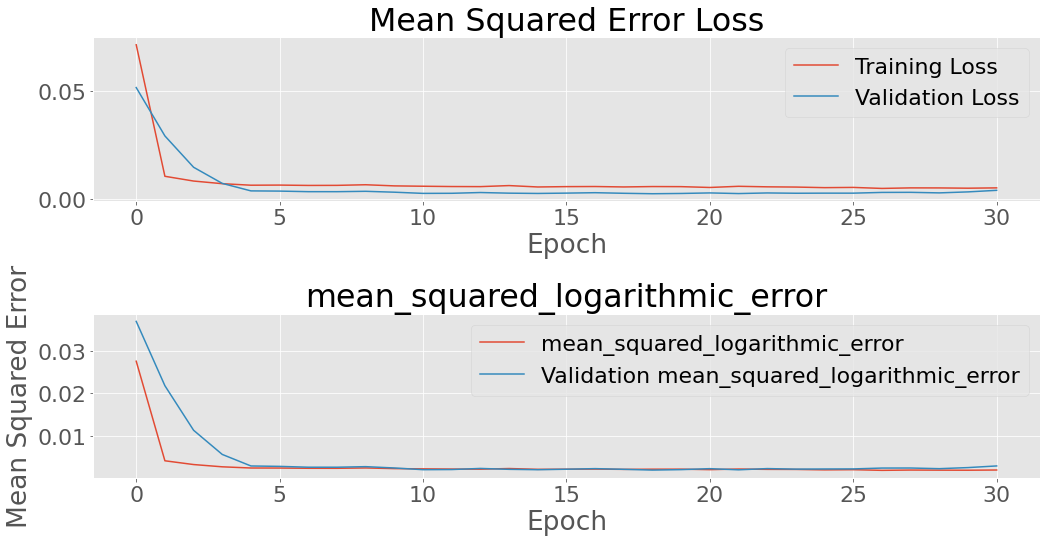

In [68]:
metrics = history.history
plt.rcParams.update({'font.size': 22})
fig, axes = plt.subplots(2, figsize=(15, 8))
axes[0].set_title('Mean Squared Error Loss')
axes[0].plot(history.epoch, metrics['loss'], metrics['val_loss'])
axes[0].legend(['Training Loss', 'Validation Loss'])
axes[0].set_xlabel('Epoch')

axes[1].set_title(metric)
axes[1].plot(history.epoch, metrics[metric], metrics['val_'+metric])
axes[1].legend([metric, 'Validation '+metric])
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Mean Squared Error')

fig.tight_layout()
plt.show()

In [69]:
prediction = model.predict(holdout['X_test'])

In [60]:
result.keys()

dict_keys(['df', 'column_scaler', 'last_sequence', 'X_train', 'y_train', 'X_test', 'y_test', 'test_df'])

actual vs prediction r2 score

bidirectional, shuffled = 0.912

bidirectional, not shuffled = 0.817

not bi, shuffled = 0.787


In [70]:
r2_score(holdout['y_test'], prediction)

0.8351365935797493

In [71]:
predictions = np.squeeze(holdout["column_scaler"]["Close"].inverse_transform(prediction))
targets = np.squeeze(holdout["column_scaler"]["Close"].inverse_transform(np.expand_dims(holdout['y_test'], axis=0)))

In [72]:
r2_score(targets, predictions)

0.8351365944447988

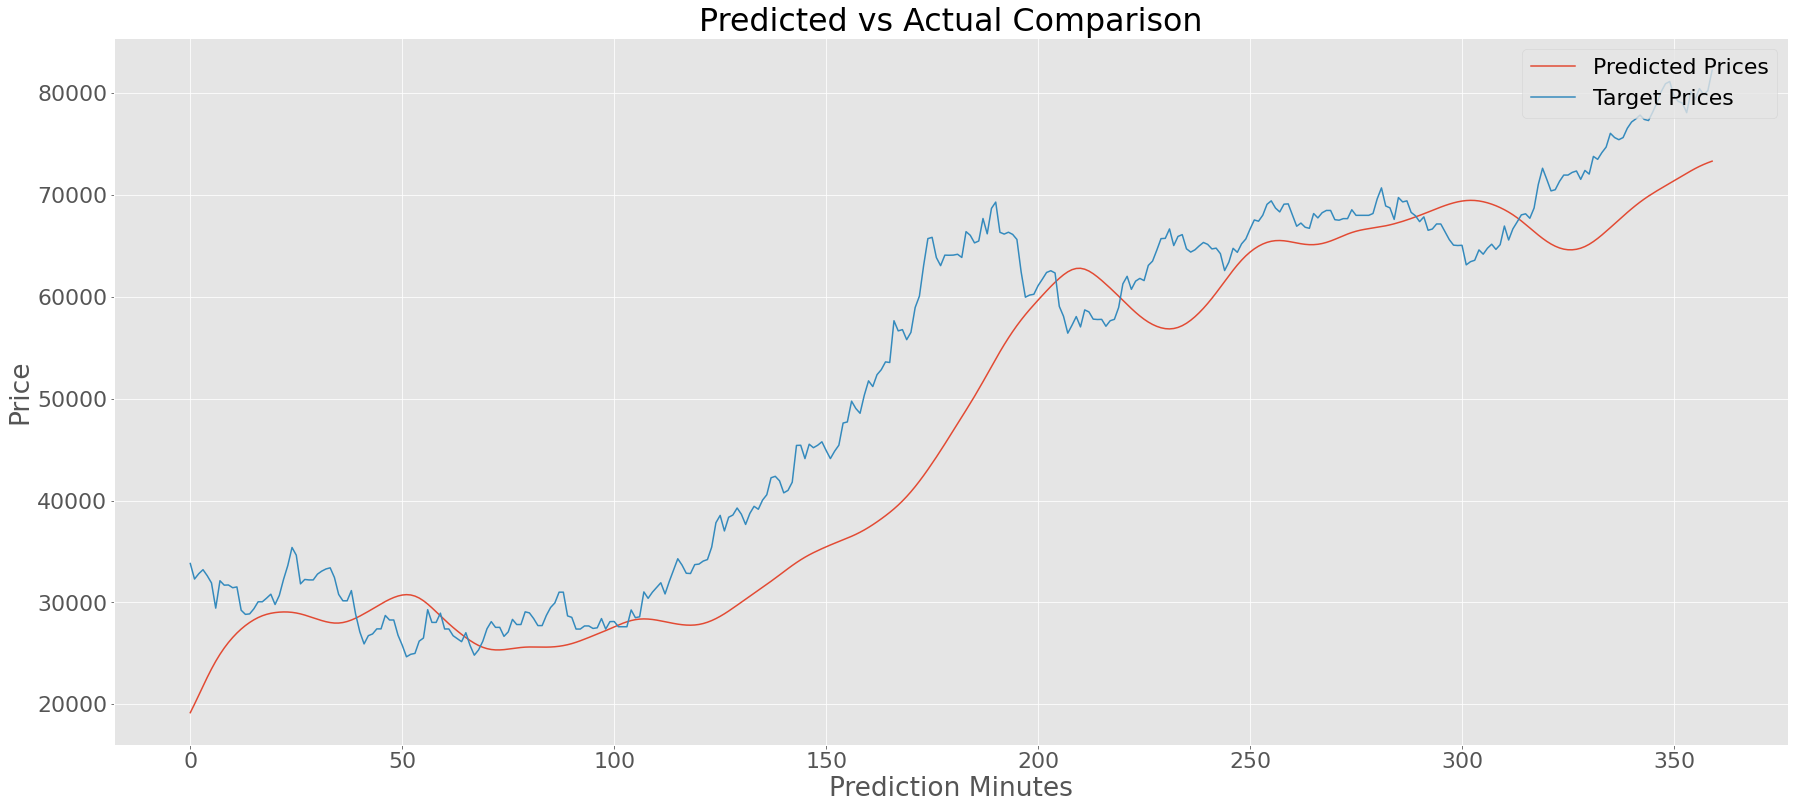

In [73]:
plt.rcParams.update({'font.size': 22})
fig, ax = plt.subplots(figsize=(30, 13))
ax.set_title("Predicted vs Actual Comparison")
ax.plot(predictions)
ax.plot(targets)
ax.legend(['Predicted Prices', 'Target Prices'], loc='upper right')

ax.set_xlabel('Prediction Minutes')
ax.set_ylabel('Price')

plt.show()

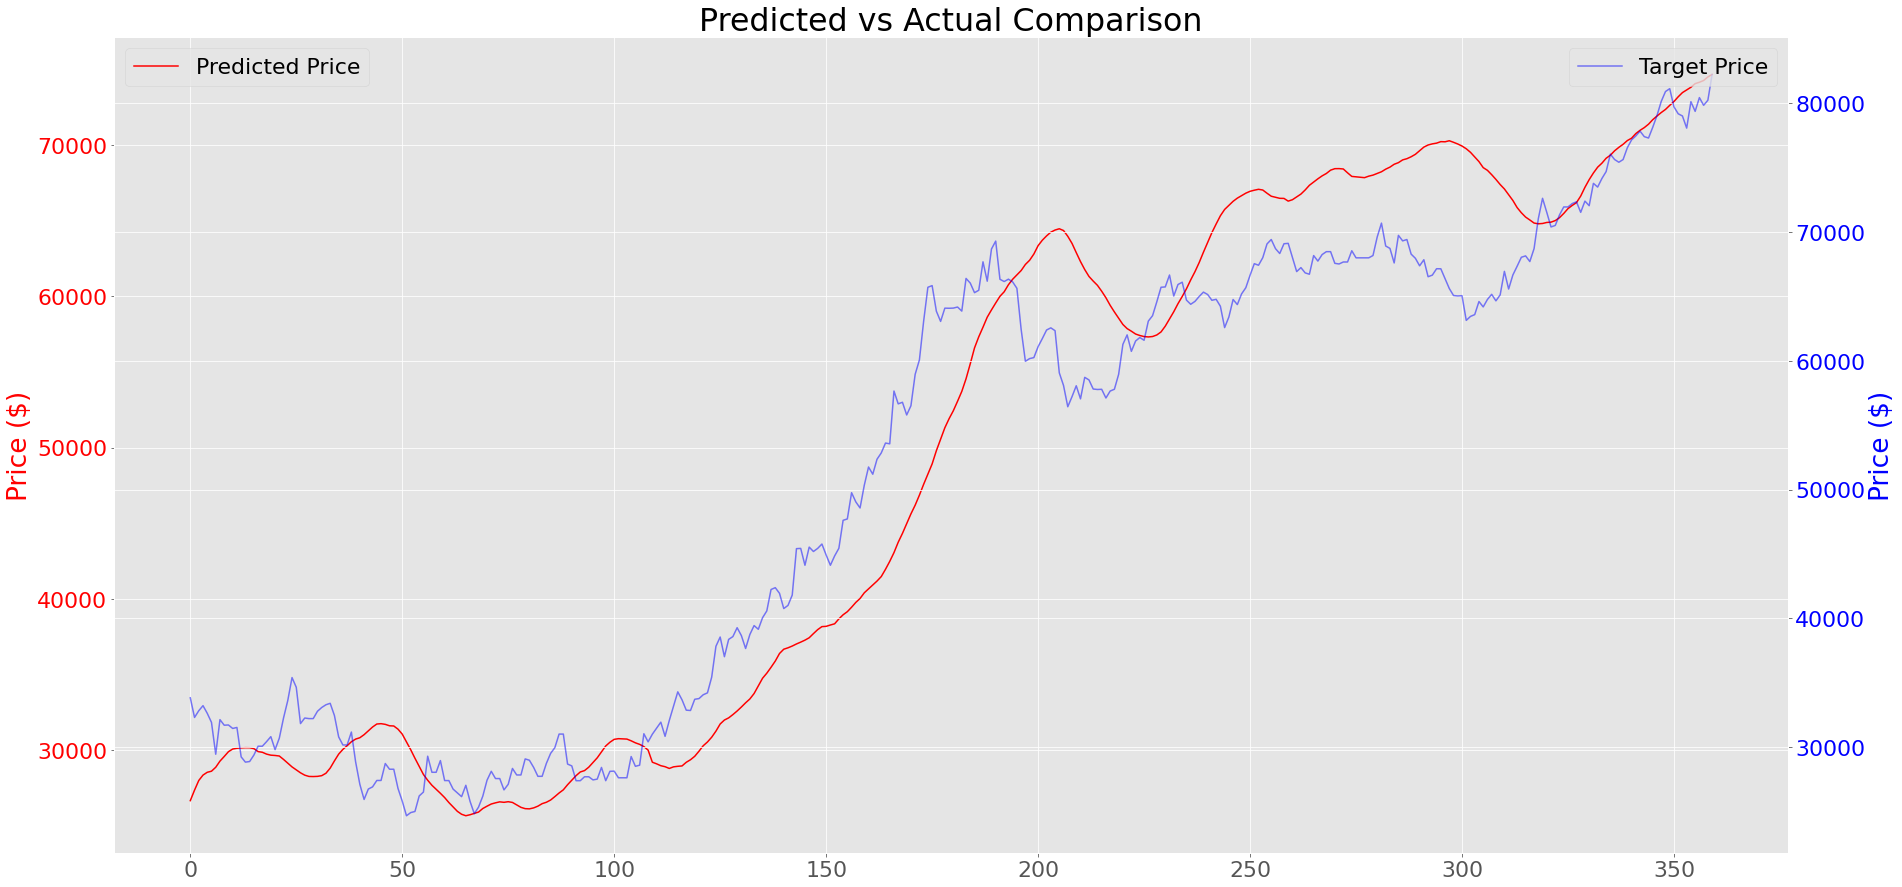

In [59]:
plt.rcParams.update({'font.size': 22})
fig, ax1 = plt.subplots(1, figsize=(30, 15))

ax1.plot(range(len(predictions)), predictions, color='r', label='Predicted Price')
ax1.set_ylabel('Price ($)', color ='r')
ax1.set_title("Predicted vs Actual Comparison")
ax1.tick_params(axis='y', labelcolor='r')
ax1.ticklabel_format(useOffset=False, style='plain')

ax2 = ax1.twinx()
ax2.plot(range(len(targets)), targets, color='b', alpha=0.5, label='Target Price')
ax2.set_ylabel('Price ($)', color ='b')
ax2.tick_params(axis='y', labelcolor='b')

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()